# Session 3 — Sentence-Level Analysis
## Measure 5: Sentence Types & Dialogue Ratio

Many literary texts mix narration with dialogue. This notebook measures:
- share of sentences in quotation marks (dialogue)
- share of interrogatives (questions) and exclamatives
- remaining narrative sentences

This helps characterize narrative style per author or per chapter.

**About Dialogue Detection:**

Our method detects sentences containing quotation marks (both straight " and curly " "). This is a **simplified heuristic** with known limitations:

**Limitations:**
- **Multi-sentence dialogue**: A single speech spanning multiple sentences will mark each as dialogue, which is correct
- **Nested quotes**: Quotes within quotes (e.g., "She said 'hello'") are treated uniformly
- **Non-dialogue quotes**: Quotation marks used for emphasis or titles will be misclassified
- **Broken dialogue**: Narrative interruptions within quoted speech (e.g., "Hello," she said, "how are you?") are handled at sentence level

**Why this approach?**
- **Simple and interpretable**: Easy to understand and implement
- **Good enough for literary analysis**: Captures the overall balance of direct speech vs narration
- **Corpus-level patterns**: Small errors average out when analyzing entire books

**Better alternatives** (not implemented here):
- Full dialogue parser tracking opening/closing quotation pairs
- NLP models trained to identify speaker attribution
- Regex patterns for common dialogue structures ("...", said X, "...")

**Why measure sentence types?**
- **Narrative pacing**: High dialogue ratio = faster pace, more character interaction
- **Genre markers**: Children's literature often has more dialogue than literary fiction
- **Author style**: Some authors prefer "showing" (dialogue) vs "telling" (narration)

We'll analyze Stephen King's two PetSemetary books, which are famous for their extensive dialogue.

In [4]:
import re
import matplotlib.pyplot as plt
import numpy as np


def load_book(filepath):
    """Load and clean book text (optionally removing Gutenberg-style headers)."""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()
    
    # Header stripping heuristics (safe even if markers are not present)
    if 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]
    
    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]
    
    return text.strip()

# Load both books
PetSemetary_text = load_book('../data/PetSemetary.txt')
TheShining_text  = load_book('../data/TheShining.txt')

print(f"PetSemetary loaded: {len(PetSemetary_text):,} characters")
print(f"TheShining loaded:  {len(TheShining_text):,} characters")


PetSemetary loaded: 812,501 characters
TheShining loaded:  906,142 characters


In [5]:
def analyze_sentence_types(text, book_name):
    """Analyze sentence types: dialogue, questions, exclamations, narrative."""
    # Split into sentences while keeping punctuation
    parts = re.split(r'([.!?]+)\s+', text)
    
    # Rebuild sentences with their punctuation
    rebuilt = []
    for i in range(0, len(parts) - 1, 2):
        if i + 1 < len(parts):
            rebuilt.append(parts[i] + parts[i + 1])
    
    # Filter very short "sentences"
    sentences = [s.strip() for s in rebuilt if s.strip() and len(s.split()) > 2]
    
    dialogue = []
    questions = []
    exclamations = []
    narrative = []
    
    for s in sentences:
        # Detect any kind of quotes: straight / curly, double and single
        has_dialogue = bool(re.search(r'[\"“”\'‘’]', s))
        is_question = '?' in s
        is_exclamation = '!' in s
        
        if has_dialogue:
            dialogue.append(s)
        if is_question:
            questions.append(s)
        if is_exclamation:
            exclamations.append(s)
        # Pure narrative = no quotes, no questions, no exclamations
        if not (has_dialogue or is_question or is_exclamation):
            narrative.append(s)
    
    total = len(sentences)
    
    print(f"\n{'='*70}")
    print(f"{book_name}")
    print(f"{'='*70}")
    print(f"Total sentences: {total:,}")
    print(f"\nSentence Types (categories can overlap):")
    print(f"  Dialogue sentences: {len(dialogue):,} ({len(dialogue)/total*100:.1f}%)")
    print(f"  Questions:          {len(questions):,} ({len(questions)/total*100:.1f}%)")
    print(f"  Exclamations:       {len(exclamations):,} ({len(exclamations)/total*100:.1f}%)")
    print(f"  Pure narrative:     {len(narrative):,} ({len(narrative)/total*100:.1f}%)")
    
    print("\nNote: A sentence can be both dialogue AND a question (e.g., 'Who are you?').")
    print("Pure narrative = sentences without quotes, questions, or exclamations.")
    
    print("\nExample dialogue sentences:")
    for sent in dialogue[:3]:
        display = sent if len(sent) < 120 else sent[:117] + "..."
        print(f"  - {display}")
    
    return {
        'total': total,
        'dialogue': len(dialogue),
        'questions': len(questions),
        'exclamations': len(exclamations),
        'narrative': len(narrative)
    }

# Analyze both books
PetSemetary_stats = analyze_sentence_types(PetSemetary_text, "PetSemetary")
TheShining_stats  = analyze_sentence_types(TheShining_text, "TheShining")



PetSemetary
Total sentences: 8,906

Sentence Types (categories can overlap):
  Dialogue sentences: 3,897 (43.8%)
  Questions:          840 (9.4%)
  Exclamations:       293 (3.3%)
  Pure narrative:     4,747 (53.3%)

Note: A sentence can be both dialogue AND a question (e.g., 'Who are you?').
Pure narrative = sentences without quotes, questions, or exclamations.

Example dialogue sentences:
  - For Kirby McCauley




                                      Introduction

   When I’m asked (as I frequently am) wha...
  - It may not be the one that scares readers the most—based on the mail,
I’d guess the one that does that is probably Th...
  - Put simply, I
was horrified by what I had written, and the conclusions I’d drawn.

TheShining
Total sentences: 11,118

Sentence Types (categories can overlap):
  Dialogue sentences: 4,448 (40.0%)
  Questions:          1,145 (10.3%)
  Exclamations:       432 (3.9%)
  Pure narrative:     6,259 (56.3%)

Note: A sentence can be both dialogue AND a questi

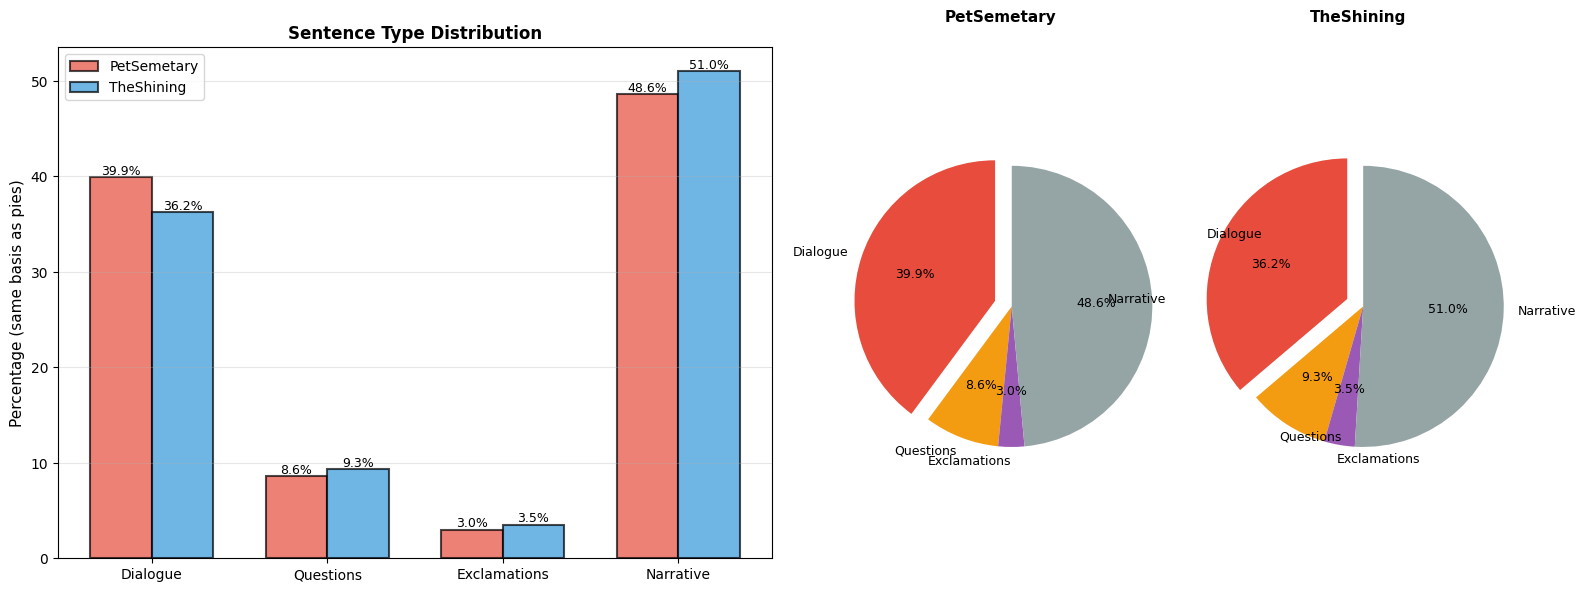

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

categories = ['Dialogue', 'Questions', 'Exclamations', 'Narrative']

# Denominators: same as used implicitly by the pies
ps_denom = (PetSemetary_stats['dialogue'] +
            PetSemetary_stats['questions'] +
            PetSemetary_stats['exclamations'] +
            PetSemetary_stats['narrative'])

ts_denom = (TheShining_stats['dialogue'] +
            TheShining_stats['questions'] +
            TheShining_stats['exclamations'] +
            TheShining_stats['narrative'])

# Now bar values match what the pies show
PetSemetary_values = [
    PetSemetary_stats['dialogue']     / ps_denom * 100,
    PetSemetary_stats['questions']    / ps_denom * 100,
    PetSemetary_stats['exclamations'] / ps_denom * 100,
    PetSemetary_stats['narrative']    / ps_denom * 100
]
TheShining_values = [
    TheShining_stats['dialogue']      / ts_denom * 100,
    TheShining_stats['questions']     / ts_denom * 100,
    TheShining_stats['exclamations']  / ts_denom * 100,
    TheShining_stats['narrative']     / ts_denom * 100
]

# --- Bar chart ---
ax1 = axes[0]
x = np.arange(len(categories))
width = 0.35

bars1 = ax1.bar(x - width/2, PetSemetary_values, width, label='PetSemetary',
                color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, TheShining_values, width, label='TheShining',
                color='#3498db', alpha=0.7, edgecolor='black', linewidth=1.5)

ax1.set_ylabel('Percentage (same basis as pies)', fontsize=11)
ax1.set_title('Sentence Type Distribution', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

for bars in (bars1, bars2):
    for bar in bars:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2.0, h,
                 f'{h:.1f}%', ha='center', va='bottom', fontsize=9)

# --- Pie charts (unchanged) ---
ax2 = axes[1]

pie_data_ps = [
    PetSemetary_stats['dialogue'],
    PetSemetary_stats['questions'],
    PetSemetary_stats['exclamations'],
    PetSemetary_stats['narrative']
]
pie_data_ts = [
    TheShining_stats['dialogue'],
    TheShining_stats['questions'],
    TheShining_stats['exclamations'],
    TheShining_stats['narrative']
]

colors_pie = ['#e74c3c', '#f39c12', '#9b59b6', '#95a5a6']
explode = (0.05, 0, 0, 0)

ax2.text(0.25, 1.05, "PetSemetary", ha='center', transform=ax2.transAxes,
         fontsize=11, fontweight='bold')
ax2.text(0.75, 1.05, "TheShining", ha='center', transform=ax2.transAxes,
         fontsize=11, fontweight='bold')

ax2.pie(pie_data_ps, labels=categories, autopct='%1.1f%%', startangle=90,
        colors=colors_pie, explode=explode, textprops={'fontsize': 9},
        radius=0.4, center=(-0.5, 0))

ax2.pie(pie_data_ts, labels=categories, autopct='%1.1f%%', startangle=90,
        colors=colors_pie, explode=explode, textprops={'fontsize': 9},
        radius=0.4, center=(0.5, 0))

ax2.set_xlim(-1, 1)
ax2.set_ylim(-0.5, 0.5)
ax2.axis('equal')

plt.tight_layout()
plt.show()